In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

data = pd.read_csv("train.csv", sep=",")
print(data.head())
print(data.info(verbose=True))


   Unnamed: 0      id  Gender      Customer Type  Age   Type of Travel  \
0           0   70172    Male     Loyal Customer   13  Personal Travel   
1           1    5047    Male  disloyal Customer   25  Business travel   
2           2  110028  Female     Loyal Customer   26  Business travel   
3           3   24026  Female     Loyal Customer   25  Business travel   
4           4  119299    Male     Loyal Customer   61  Business travel   

      Class  Flight Distance  Inflight wifi service  \
0  Eco Plus              460                      3   
1  Business              235                      3   
2  Business             1142                      2   
3  Business              562                      2   
4  Business              214                      3   

   Departure/Arrival time convenient  ...  Inflight entertainment  \
0                                  4  ...                       5   
1                                  2  ...                       1   
2                

In [3]:
#Вывод выборочных данных и замена данных на значения
print(data['Gender'].value_counts(), '\n')
print(data['Customer Type'].value_counts(), '\n')
print(data['Type of Travel'].value_counts(), '\n')
print(data['Class'].value_counts(), '\n')
print(data['satisfaction'].value_counts(), '\n')

print('Number of missing data for Inflight wifi service', (data['Inflight wifi service'] == 0).sum())
print('Number of avaiable data for Inflight wifi service', (data['Inflight wifi service'] != 0).sum())
data = data[data['Inflight wifi service'] != 0]
data = data[data['Class'] != 'Eco Plus']

data['Gender'] = data['Gender'].map({'Female': 0, 'Male': 1})
data['Customer Type'] = data['Customer Type'].map({'Loyal Customer': 0, 'disloyal Customer': 1})
data['Type of Travel'] = data['Type of Travel'].map({'Business travel': 0, 'Personal Travel': 1})
data['Class'] = data['Class'].map({'Business': 0, 'Eco': 1})
data['satisfaction'] = data['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})

data = data.drop('id', axis=1)
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

Gender
Female    52727
Male      51177
Name: count, dtype: int64 

Customer Type
Loyal Customer       84923
disloyal Customer    18981
Name: count, dtype: int64 

Type of Travel
Business travel    71655
Personal Travel    32249
Name: count, dtype: int64 

Class
Business    49665
Eco         46745
Eco Plus     7494
Name: count, dtype: int64 

satisfaction
neutral or dissatisfied    58879
satisfied                  45025
Name: count, dtype: int64 

Number of missing data for Inflight wifi service 3103
Number of avaiable data for Inflight wifi service 100801


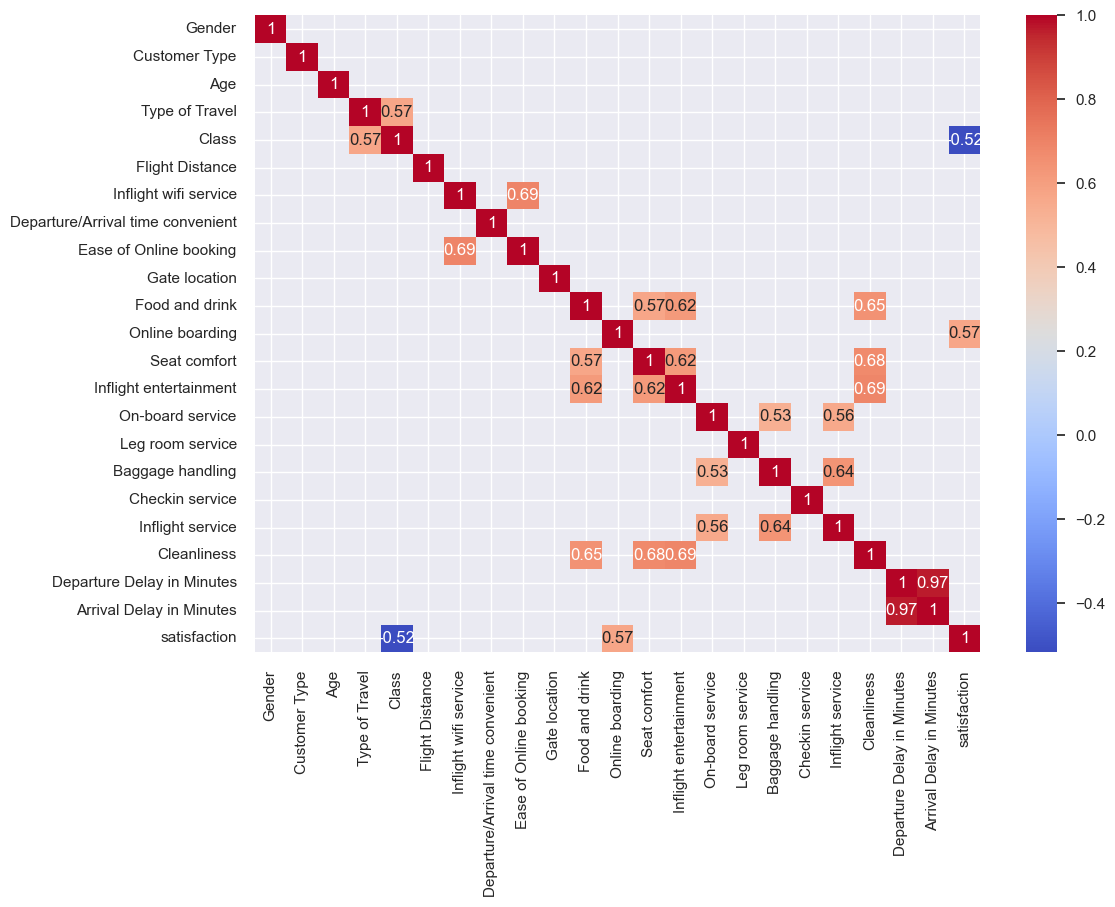

In [4]:
#График корреляций
correlations = data.corr()
threshold = 0.5
high_correlations = correlations[(correlations >= threshold) | (correlations <= -1*threshold)]
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(high_correlations, annot=True, cmap='coolwarm')
plt.show()

In [5]:
#Метод главных компонент
data = data.drop(['Arrival Delay in Minutes'], axis=1)

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

pca = PCA(n_components=3, random_state=42)
pca.fit(data_scaled)
data_pca = pd.DataFrame(pca.transform(data_scaled), columns=(['col1', 'col2', 'col3']))
data_pca.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,93502.0,-2.427952e-17,2.166748,-5.850861,-1.714796,-0.088307,1.830024,5.171134
col2,93502.0,4.559535e-17,1.551767,-4.327497,-1.103380,0.012849,1.157272,4.314149
col3,93502.0,-4.316360e-17,1.473922,-4.782020,-0.955478,0.056586,1.007794,4.560875


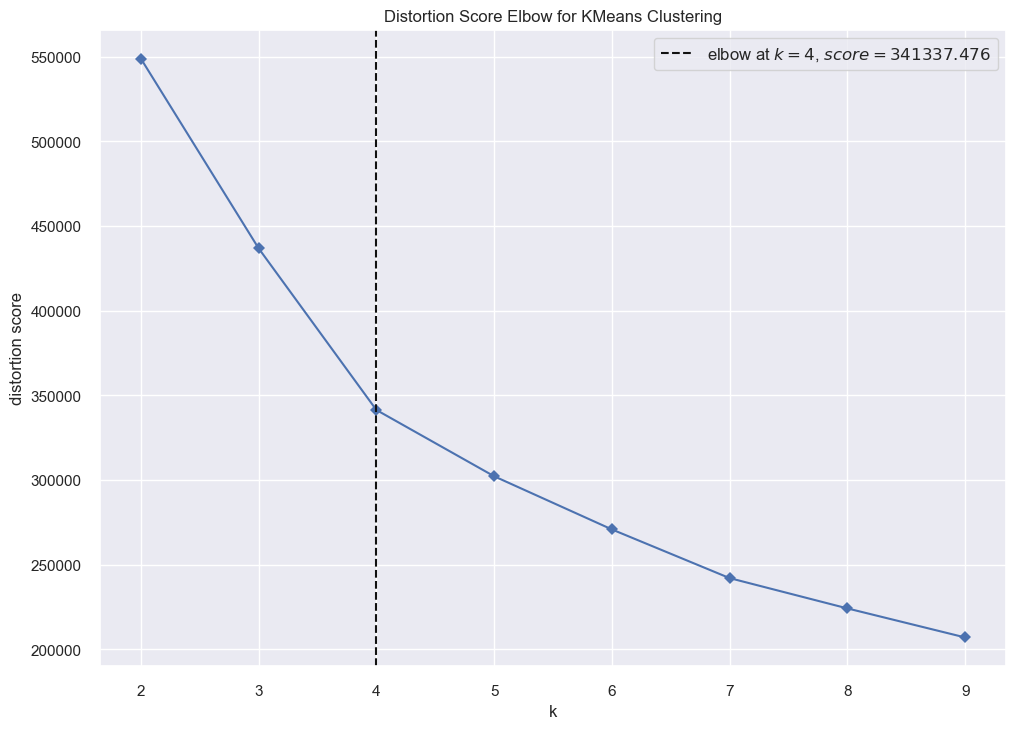

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [6]:
#Метод локтя
elbow = KElbowVisualizer(KMeans(n_init=10), k=(2, 10), timings=False, locate_elbow=True)
elbow.fit(data_pca)
elbow.show()

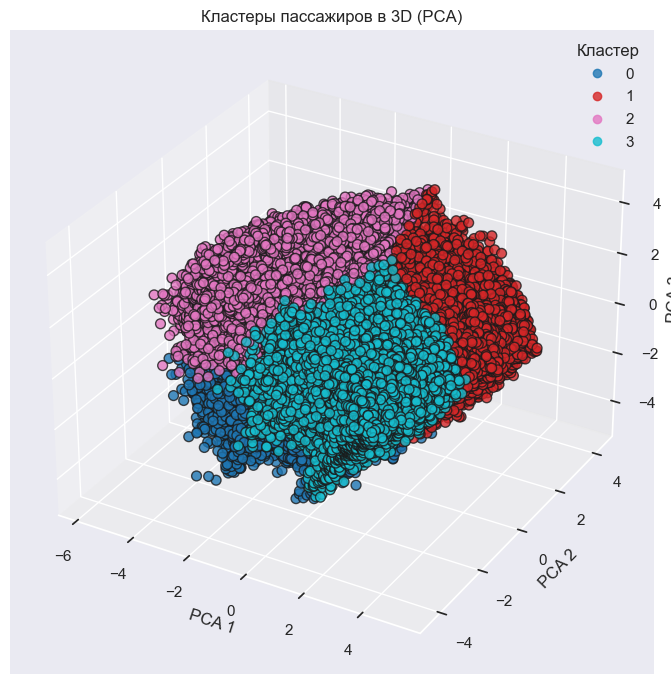

In [7]:
data_scaled = pd.DataFrame(data_scaled, columns = data.columns)

# используем k = 4 с метода локтя
model = KMeans(n_clusters=4, random_state=42, n_init=10)
predictions = model.fit_predict(data_pca)
data_pca['Cluster'] = predictions
data['Cluster'] = predictions
data_scaled['Cluster'] = predictions

# строим график кластеров
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(data_pca['col1'], data_pca['col2'], data_pca['col3'],
                     c=data_pca['Cluster'], cmap='tab10', s=50, edgecolor='k', alpha=0.8)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('Кластеры пассажиров в 3D (PCA)')
plt.legend(*scatter.legend_elements(), title="Кластер", loc='best')
plt.tight_layout()
plt.show()

C:\Users\tadzh\AppData\Local\Temp\ipykernel_3124\12677827.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Cluster', palette='Set3', edgecolor='black')


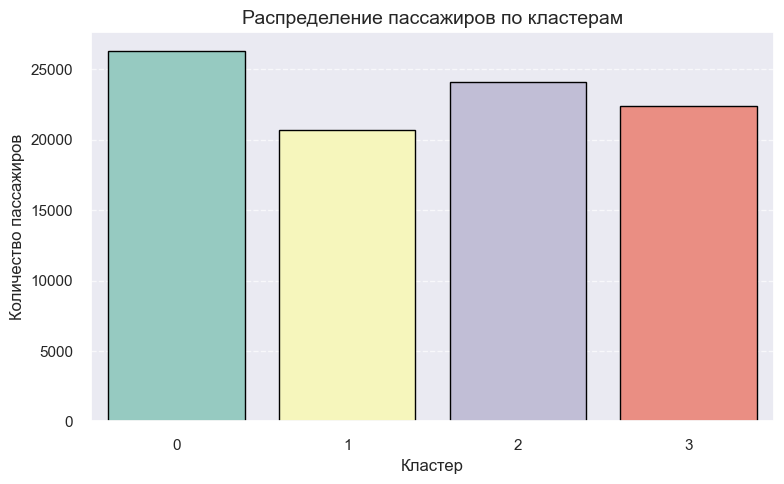

In [8]:
#График распределения кластеров по числу людей
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='Cluster', palette='Set3', edgecolor='black')
plt.title('Распределение пассажиров по кластерам', fontsize=14)
plt.xlabel('Кластер')
plt.ylabel('Количество пассажиров')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [24]:
#Строим градиентный график для изучения кластеров
cluster = data.groupby(['Cluster']).mean().T
cluster.style.background_gradient(cmap='RdYlGn',axis=1)

Cluster,0,1,2,3
Gender,0.567039,0.497741,0.478594,0.443740
Customer Type,0.318455,0.146612,0.113625,0.177434
Age,33.482918,41.325873,42.016279,41.882535
Type of Travel,0.499742,0.165503,0.098974,0.396909
Class,0.775107,0.266530,0.197786,0.663988
Flight Distance,831.785064,1497.252156,1586.480873,1043.740804
Inflight wifi service,2.404120,1.981314,4.096533,2.591345
Departure/Arrival time convenient,3.155365,1.986242,3.976721,2.960587
Ease of Online booking,2.553820,1.870021,4.048022,2.721484
Gate location,2.981116,1.862012,3.858375,3.003091
